# Library imports

In [21]:
import numpy as np # for numerical operations
import sklearn # for machine learning tools
import matplotlib.pyplot as pyplot # for data visualization

from sklearn.cluster import KMeans # for K-Means clustering
from sklearn.decomposition import PCA # for Principal Component Analysis (dimensionalisation)
from sklearn.datasets import load_digits # load digit image data
from time import time # for measuring execution time 
from sklearn import metrics # for various evaluation metrics
from sklearn.pipeline import make_pipeline # for creating pipelines
from sklearn.preprocessing import StandardScaler # for data preprocessing


# Loading the dataset

In [22]:
# Loading digit image dataset and obtaining data and labels
data, labels = load_digits(return_X_y=True)
# Getting number of samples (data points) and number of features (dimensions)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size
print(f'# digits: {n_digits}; # samples: {n_samples}; # features: {n_features}')

# digits: 10; # samples: 1797; # features: 64


# Define evaluation benchmark
The evaluation benchmark is a function that returns the effectiveness of the KNN clustering model.

Because unsupervised learning lacks labels, you cannot compare the predicted values to the true values. Thereby, we use different metrics, as listed below to measure model efficiency. 

In [23]:
def bench_k_means(kmeans, name, data, labels):
    # Record starting time
    t0 = time()
    # Create pipeline with StandardScaler and KMeans, then fit it to data
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    # Calculate time taken for fitting
    fit_time = time() - t0
    # Initialize list to store results
    results = [name, fit_time, estimator[-1].inertia_]
    # Define clustering evaluation metrics, generally the higher the better
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    # Compute and store clustering metrics
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]
    # Calculate and store silhouette score
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=100,
        )
    ]

    # Display results using formatted output
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))


# Running the benchmark
We will compare three approaches:

* an initialization using k-means++. This method is stochastic (outcomes based upon random probability) and we will run the initialization 4 times;

* a random initialization. This method is stochastic as well and we will run the initialization 4 times;

* an initialization based on a PCA projection. Indeed, we will use the components of the PCA to initialize KMeans. This method is deterministic and a single initialization suffice.

In [24]:
# Printing a separator line for clarity
print(82 * "_")
# Printing a header for the output table
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

# Creating a KMeans instance using "k-means++" initialization method
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
# Evaluating K-Means clustering with the given initialization method
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

# Creating another KMeans instance using "random" initialization method
kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
# Evaluating K-Means clustering with the "random" initialization method
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

# Performing Principal Component Analysis (PCA) on the data
pca = PCA(n_components=n_digits).fit(data)
# Creating a KMeans instance using PCA components for initialization
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
# Evaluating K-Means clustering with PCA-based initialization
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)


__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.070s	69545	0.598	0.645	0.621	0.469	0.617	0.137
random   	0.047s	69735	0.681	0.723	0.701	0.574	0.698	0.148
PCA-based	0.011s	72686	0.636	0.658	0.647	0.521	0.643	0.152


From this data, we can determine that PCA-based clustering is the most effective, with the shortest time, and highest inertia, homogenity, completness, v-measure, etc. 

# Visualize the results on PCA-reduced data

PCA allows to project the data from the original 64-dimensional space into a lower dimensional space. Subsequently, we can use PCA to project into a 2-dimensional space and plot the data and the clusters in this new space.

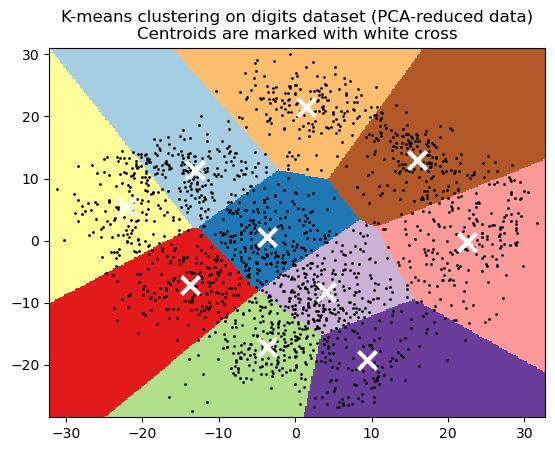

In [25]:
# reduce data to 2 dimensions using PCA
reduced_data = PCA(n_components=2).fit_transform(data)
# initialize KMeans clustering with specified number of clusters
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)

# fit KMeans model to reduced data
kmeans.fit(reduced_data)

# define step size for creating mesh for plotting decision boundary
h = 0.2  # step size

# define boundaries of mesh based on reduced data
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

# create meshgrid of points based on defined boundaries
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# predicts cluster labels for each point in mesh using trained model
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# reshape cluster labels to match shape of mesh
Z = Z.reshape(xx.shape)

# plot cluster decision boundaries
pyplot.figure(1)  # create new figure
pyplot.clf()  # clear existing content from figure
pyplot.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=pyplot.cm.Paired,
    aspect="auto",
    origin="lower",
)  # display  decision boundaries as an image

# plot original data points as small black dots
pyplot.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot centroids of clusters as white X marks
centroids = kmeans.cluster_centers_
pyplot.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)

# add title and set plot limits
pyplot.title(
    "K-means clustering on digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
pyplot.xlim(x_min, x_max)
pyplot.ylim(y_min, y_max)
pyplot.show()

Each white cross is a centroid, and each area is a cluster. If we place a datapoint in this graph, and in this model, it will classify based on which cluster it is in. 